In [1]:
import pandas as pd
import numpy as np
import itertools 
from sklearn.model_selection import train_test_split
from sklearn import linear_model, svm
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix,accuracy_score, recall_score, roc_auc_score, auc, f1_score
import matplotlib.pyplot as plt
import datetime
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import plot_tree
from xgboost import plot_importance
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import category_encoders as ce

from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV

C:\Users\RAUL\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\RAUL\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.options.display.max_columns = 999

In [4]:
file = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\Data\\events_TP2.csv'
testFile = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\Data\\events_TEST.csv'
trainingFile = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\Data\\events_TRAINING.csv'

In [5]:
df = pd.read_csv(file)

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [7]:
df.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.sort_values(['person', 'timestamp'] , inplace = True)

In [9]:
df['timestamp'].max() - datetime.timedelta(days=15)

Timestamp('2018-05-16 23:59:59')

In [10]:
personas = df[['person']].drop_duplicates()

In [11]:
def sesiones_feature(df, personas, tiempo_inactividad, dias): #esta funcion analiza las sesiones de los usuarios considerando "sesiones" al conjunto de actividades seguidas sin que pase un tiempo determinado como tiempo de inactividad
    df = df[df['timestamp'] >= (df['timestamp'].max() - datetime.timedelta(days=dias))]
    gt_30min = df.timestamp.diff() > datetime.timedelta(minutes=tiempo_inactividad)
    diff_user = df.person != df.person.shift()
    df['# Visita'] = (diff_user | gt_30min).cumsum()
    
    cantidad_sesiones_col = 'cant_sesiones_inac' + str(tiempo_inactividad) + 'MIN_ult_' + str(dias) + '_dias' 
    promedio_sesiones_sec_col = 'promedio_sesiones_sec_inac' + str(tiempo_inactividad) + 'MIN_ult_' + str(dias) + '_dias' 
    tiempo_total_sesiones_sec_col = 'tiempo_total_sesiones_sec_inac' + str(tiempo_inactividad) + 'MIN_ult_' + str(dias) + '_dias' 
    
    duracion_sesiones = pd.DataFrame(df.groupby(['person', '# Visita'])['timestamp'].agg(lambda x : x.max() - x.min())).reset_index()
    sumas_sesiones = pd.DataFrame(duracion_sesiones.groupby('person')['timestamp'].sum()).reset_index().rename(columns = {'timestamp' : 'sum'})
    cantidad_sesiones =  pd.DataFrame(duracion_sesiones.groupby('person')['timestamp'].count()).reset_index().rename(columns = {'timestamp' : cantidad_sesiones_col})
    sesiones = sumas_sesiones.merge(cantidad_sesiones, on = 'person')   
    sesiones['promedio_sesiones'] = pd.to_timedelta(pd.to_timedelta(sesiones['sum'])/sesiones[cantidad_sesiones_col], unit = 'ns').dt.round('1s')
    sesiones[promedio_sesiones_sec_col] = sesiones['promedio_sesiones'].dt.total_seconds()
    sesiones[tiempo_total_sesiones_sec_col] = sesiones['sum'].dt.total_seconds()
    del sesiones['promedio_sesiones']
    del sesiones['sum']
    return personas.merge(sesiones, on = 'person', how = 'left').fillna(0)

In [12]:
#act30 = df[df['timestamp'] >= pd.to_datetime('2018-04-30')].groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : '#act_ult30dias'})

In [13]:
def marcas_vistas_feature(df, personas): #Esta funcion analiza las marcas más vistas por cada usuario
    samsung_vistos = df[(df['event'] == 'viewed product') & (df['model'].str.lower().str.contains('samsung') == True)].groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : 'samsung_vistos'})
    iphone_vistos  = df[(df['event'] == 'viewed product') & (df['model'].str.lower().str.contains('iphone') == True)].groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : 'iphone_vistos'})
    motorola_vistos = df[(df['event'] == 'viewed product') & (df['model'].str.lower().str.contains('motorola') == True)].groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : 'motorola_vistos'})
    marcas_vistas = samsung_vistos.merge(iphone_vistos, on = 'person', how = 'left').fillna(0)
    marcas_vistas = marcas_vistas.merge(motorola_vistos, on = 'person', how = 'left').fillna(0)
    marcas_vistas['total_marcas_vistas'] = marcas_vistas['samsung_vistos'] + marcas_vistas['iphone_vistos'] + marcas_vistas['motorola_vistos']
    marcas_vistas['%_vistos_samsung'] = marcas_vistas['samsung_vistos'] / marcas_vistas['total_marcas_vistas']
    marcas_vistas['%_vistos_motorola'] = marcas_vistas['motorola_vistos'] / marcas_vistas['total_marcas_vistas']
    marcas_vistas['%_vistos_iphone'] = marcas_vistas['iphone_vistos'] / marcas_vistas['total_marcas_vistas']
    personas = personas.merge(marcas_vistas, on = 'person', how = 'left')
    personas['total_marcas_vistas'] = personas['total_marcas_vistas'].fillna(0)
    personas['%_vistos_samsung'] = personas['%_vistos_samsung'].fillna(0)
    personas['%_vistos_iphone'] = personas['%_vistos_iphone'].fillna(0)
    personas['%_vistos_motorola'] = personas['%_vistos_motorola'].fillna(0)
    personas['samsung_vistos'] = personas['samsung_vistos'].fillna(0)
    personas['iphone_vistos'] = personas['iphone_vistos'].fillna(0)
    personas['motorola_vistos'] = personas['motorola_vistos'].fillna(0)
    return personas

In [14]:
def modelos_vistos_feature(df, personas): #Esta funcion analiza los modelos vistos por las personas
    modelos_vistos = df[df['event'] == 'viewed product'].groupby('person')['model'].agg({'modelos_vistos': 'count','modelos_distintos': 'nunique'})
    sku_vistos = df[df['event'] == 'viewed product'].groupby('person')['sku'].agg({'sku_distintos': 'nunique'})
    vistos = modelos_vistos.merge(sku_vistos, on  = 'person')
    personas = personas.merge(vistos, on = 'person', how = 'left')
    personas['modelos_vistos'] = personas['modelos_vistos'].fillna(0)
    personas['modelos_distintos'] = personas['modelos_distintos'].fillna(0)
    personas['sku_distintos'] = personas['sku_distintos'].fillna(0)
    return personas

Analizaremos los caminos que realizan las personas antes de comprar

In [15]:
def modelos_vistos_ult_x_dias(df, personas, dias): #Analiza los modelos vistos en los x dias atras de la ultima fecha del df
    df = df[df['timestamp'] >= (df['timestamp'].max() - datetime.timedelta(days=dias))]
    
    mas_visto_col = 'mod_mas_visto_ult_' + str(dias) + '_dias'
    total_vistos_col = 'total_vistos_ult_' + str(dias) + '_dias'
    por_mas_vistos_col = '%_mas_visto_ult_' + str(dias) + '_dias' 
    
    modelos_mas_vistos = pd.DataFrame(df[df['event'] == 'viewed product'].groupby('person')['model'].agg(lambda x:x.value_counts()[0])).reset_index().rename(columns = {'model' : mas_visto_col})
    total_vistos = pd.DataFrame(df[df['event'] == 'viewed product'].groupby('person')['model'].count().reset_index().rename(columns = {'model' : total_vistos_col}))

    modelos_mas_vistos = modelos_mas_vistos.merge(total_vistos, on = 'person')
    modelos_mas_vistos[por_mas_vistos_col] = modelos_mas_vistos[mas_visto_col]/modelos_mas_vistos[total_vistos_col]
    
    personas = personas.merge(modelos_mas_vistos, how = 'left', on = 'person')
    
    personas[por_mas_vistos_col] = personas[por_mas_vistos_col].fillna(0)
    personas[mas_visto_col] = personas[mas_visto_col].fillna(0)
    personas[total_vistos_col] = personas[total_vistos_col].fillna(0)
    
    return personas

In [16]:
def compro(x):
    if('conversion' in x):
        return True
    else:
        return False
    
def borrarRepe(lista):
    return [x[0] for x in itertools.groupby(lista)]

def eliminarConv(x):
    if('conversion' in x):
        return x.remove('conversion')
    else:
        return x

In [17]:
maxdate = max(df['timestamp'])

In [18]:
maxdate.date()

datetime.date(2018, 5, 31)

In [19]:
def caminos_feature(df, personas): #esta funcion analiza los "caminos" que llevan a la compra de los usuarios
    ultima_fecha = pd.to_datetime(max(df['timestamp']))
    paths = df.sort_values(by = 'timestamp').copy()
    paths['#Camino'] = paths.groupby('person')['event'].apply(lambda x : x.eq('conversion').shift().fillna(0).cumsum())
    #Veremos la cantidad de modelos y Sku vistos en cada camino
    paths2 = paths.groupby(['person','#Camino'])['event'].apply(list).reset_index().rename(columns = {'event' : 'camino'})
    camino = paths.groupby(['person','#Camino'])['event'].apply(list).reset_index().rename(columns = {'event' : 'camino'})['camino']
    paths2['compro'] = paths2['camino'].apply(lambda x : compro(x))
    paths2.rename(columns = {'camino' : 'camino_sin_compra'}, inplace = True)
    paths2['camino_con_compra'] = camino.copy()
    paths2['#pasos_antes_comprar'] = paths2['camino_sin_compra'].apply(lambda x : len(x))
    camino2 = paths2['camino_sin_compra'].copy()
    paths2['camino_sin_compra_sin_rep'] = camino2.apply(lambda x : borrarRepe(x))
    paths2 = paths2.merge(paths.groupby(['person', '#Camino'])['timestamp'].agg({'primer_paso_time' : 'min', 'ultimo_paso_time' : 'max'}), on = ['person','#Camino'])
    paths2['primer_paso_date'] = pd.to_datetime(paths2['primer_paso_time'].dt.date)
    paths2['ultimo_paso_date'] = pd.to_datetime(paths2['ultimo_paso_time'].dt.date)
    paths2['primera_actividad_ultimo_paso'] = (ultima_fecha - paths2['primer_paso_date']).dt.days
    paths2['ultima_actividad'] = (ultima_fecha - paths2['ultimo_paso_date']).dt.days
    del paths2['primer_paso_time']
    del paths2['ultimo_paso_time']
    del paths2['camino_sin_compra']
    del paths2['camino_con_compra']
    del paths2['camino_sin_compra_sin_rep']
    del paths2['primer_paso_date']
    del paths2['ultimo_paso_date']
    personas =  personas.merge(paths2, on = 'person', how = 'left')
    personas.drop_duplicates(subset = 'person', keep = 'last', inplace = True)
    return personas

In [20]:
def primera_actividad_feature(df, personas):#Analiza en qué fecha se realizo la primera actividad
    ultima_fecha = pd.to_datetime(max(df['timestamp']))
    primera_actividad = df.groupby('person')['timestamp'].min().reset_index().rename(columns = {'timestamp' : 'fecha_primera_actividad'})
    primera_actividad['fecha_primera_actividad'] = pd.to_datetime(primera_actividad['fecha_primera_actividad'].dt.date)
    primera_actividad['primera_actividad'] = (ultima_fecha - primera_actividad['fecha_primera_actividad']).dt.days
    del primera_actividad['fecha_primera_actividad']
    return personas.merge(primera_actividad, on = 'person', how ='left')

In [21]:
def cantidad_de_actividades_feature(df, personas):#Analiza la cantidad de actividades de cada persona
    actividades = df.groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : '# Actividades'})
    return personas.merge(actividades, on = 'person', how ='left')

In [22]:
def actividad_ult_x_dias(df, personas, dias):# Analiza la cantidad de actividades en los ultimos X dias
    col_name = 'act_ult_' + str(dias) + '_dias'
    act_dias = pd.DataFrame(df[df['timestamp'] >= (df['timestamp'].max() - datetime.timedelta(days=dias))].groupby('person')['timestamp'].count()).reset_index().rename(columns = {'timestamp' : col_name})
    personas = personas.merge(act_dias, on = 'person', how = 'left') 
    personas[col_name] = personas[col_name].fillna(0)
    
    return personas

In [23]:
def checkout_ult_x_dias(df, personas, dias):# Analiza la cantidad de checkouts en los ultimos X dias
    col_name = 'check_ult_' + str(dias) + '_dias'
    chk_dias = pd.DataFrame(df[(df['timestamp'] >= (df['timestamp'].max() - datetime.timedelta(days=dias))) & (df['event'] == 'checkout')].groupby('person')['timestamp'].count()).reset_index().rename(columns = {'timestamp' : col_name})
    personas = personas.merge(chk_dias, on = 'person', how = 'left') 
    personas[col_name] = personas[col_name].fillna(0)
    
    return personas

In [24]:
def ultimo_checkout(df, personas):#Analiza cuando realizo el ultimo checkout
    ultima_fecha = df['timestamp'].max()
    ult_check = df[df['event'] == 'checkout'].groupby('person')['timestamp'].max().reset_index().rename(columns = {'timestamp' : 'ult_checkout'}) 
    ult_check['ult_checkout_dias']  = (ultima_fecha - ult_check['ult_checkout']).dt.days
    ult_check['ult_checkout_segundos']  = (ultima_fecha - ult_check['ult_checkout']).dt.total_seconds()
    del ult_check['ult_checkout']
    
    return personas.merge(ult_check, on = 'person', how = 'left')

In [25]:
def mod_dist_check_ult_x_dias(df, personas, dias):#Analiza la cantidad de modelos distintos que puso en checkout en los ultimos X días
    col_name = 'mod_dist_check_ult_' + str(dias) + '_dias'
    mod_dias = pd.DataFrame(df[(df['timestamp'] >= (df['timestamp'].max() - datetime.timedelta(days=dias))) & (df['event'] == 'checkout')].groupby('person')['model'].nunique()).reset_index().rename(columns = {'model' : col_name})
    personas = personas.merge(mod_dias, on = 'person', how = 'left') 
    personas[col_name] = personas[col_name].fillna(0)
    return personas


In [26]:
def conv_ult_x_dias(df, personas, dias):#Analiza la cantidad de conversiones en los ultimos X dias
    col_name = 'conv_ult_' + str(dias) + '_dias'
    act_dias = pd.DataFrame(df[(df['timestamp'] >= (df['timestamp'].max() - datetime.timedelta(days=dias))) & (df['event'] == 'conversion')].groupby('person')['timestamp'].count()).reset_index().rename(columns = {'timestamp' : col_name})
    personas = personas.merge(act_dias, on = 'person', how = 'left') 
    personas[col_name] = personas[col_name].fillna(0)
    
    return personas

In [27]:
def info_demografica(df, personas):    
    paises = df.groupby('person')['country'].first().reset_index()
    regiones = df.groupby('person')['region'].first().reset_index()
    ciudades = df.groupby('person')['city'].first().reset_index()

    demografica = paises.merge(regiones, on = 'person')
    demografica = demografica.merge(ciudades, on = 'person')

    encoder = ce.BinaryEncoder(cols=['country', 'region', 'city'])
    demografica_binary = encoder.fit_transform(demografica)

    return personas.merge(demografica_binary, on = 'person', how = 'left')

In [28]:
personas = sesiones_feature(df, personas, 45, 9999)
personas = sesiones_feature(df, personas, 45, 30)
personas = sesiones_feature(df, personas, 45, 25)
personas = sesiones_feature(df, personas, 45, 20)
personas = sesiones_feature(df, personas, 45, 15)
personas = sesiones_feature(df, personas, 45, 10)
personas = sesiones_feature(df, personas, 45, 5)
personas = sesiones_feature(df, personas, 45, 1)

In [29]:
personas = sesiones_feature(df, personas, 30, 9999)
personas = sesiones_feature(df, personas, 30, 30)
personas = sesiones_feature(df, personas, 30, 25)
personas = sesiones_feature(df, personas, 30, 20)
personas = sesiones_feature(df, personas, 30, 15)
personas = sesiones_feature(df, personas, 30, 10)
personas = sesiones_feature(df, personas, 30, 5)
personas = sesiones_feature(df, personas, 30, 1)

In [30]:
personas = marcas_vistas_feature(df, personas)

In [31]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,00091926,31,708.0,21934.0,31.0,708.0,21934.0,27.0,761.0,20544.0,22.0,756.0,16625.0,14.0,830.0,11623.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,34,438.0,14890.0,34.0,438.0,14890.0,30.0,450.0,13500.0,24.0,505.0,12116.0,15.0,610.0,9149.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,61.0,251.0,55.0,367.0,0.166213,0.149864,0.683924
2,00091a7a,1,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,000ba417,5,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,2.0,4813.0,9626.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,2.0,4813.0,9626.0,0.0,0.0,0.0,0.0,0.0,0.0,105.0,8.0,35.0,148.0,0.709459,0.236486,0.054054
4,000c79fe,1,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,0.0,0.0,0.0,1,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [32]:
personas = modelos_vistos_feature(df, personas)

In [33]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,00091926,31,708.0,21934.0,31.0,708.0,21934.0,27.0,761.0,20544.0,22.0,756.0,16625.0,14.0,830.0,11623.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,34,438.0,14890.0,34.0,438.0,14890.0,30.0,450.0,13500.0,24.0,505.0,12116.0,15.0,610.0,9149.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,61.0,251.0,55.0,367.0,0.166213,0.149864,0.683924,372.0,36.0,164.0
2,00091a7a,1,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.0,3.0,3.0
3,000ba417,5,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,2.0,4813.0,9626.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,2.0,4813.0,9626.0,0.0,0.0,0.0,0.0,0.0,0.0,105.0,8.0,35.0,148.0,0.709459,0.236486,0.054054,153.0,26.0,81.0
4,000c79fe,1,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,0.0,0.0,0.0,1,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.0,1.0,1.0


In [34]:
personas = modelos_vistos_ult_x_dias(df, personas, 9999)
personas = modelos_vistos_ult_x_dias(df, personas, 30)
personas = modelos_vistos_ult_x_dias(df, personas, 25)
personas = modelos_vistos_ult_x_dias(df, personas, 20)
personas = modelos_vistos_ult_x_dias(df, personas, 15)
personas = modelos_vistos_ult_x_dias(df, personas, 10)
personas = modelos_vistos_ult_x_dias(df, personas, 5)
personas = modelos_vistos_ult_x_dias(df, personas, 1)

In [35]:
personas.sample(10)

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias
35254,e84bb55e,1,980.0,980.0,1.0,980.0,980.0,1.0,980.0,980.0,1.0,980.0,980.0,1.0,980.0,980.0,1.0,980.0,980.0,1.0,980.0,980.0,1.0,980.0,980.0,1,980.0,980.0,1.0,980.0,980.0,1.0,980.0,980.0,1.0,980.0,980.0,1.0,980.0,980.0,1.0,980.0,980.0,1.0,980.0,980.0,1.0,980.0,980.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,15.0,3.0,11.0,10.0,15.0,0.666667,10.0,15.0,0.666667,10.0,15.0,0.666667,10.0,15.0,0.666667,10.0,15.0,0.666667,10.0,15.0,0.666667,10.0,15.0,0.666667,10.0,15.0,0.666667
23324,9a886433,3,63.0,189.0,3.0,63.0,189.0,2.0,88.0,176.0,1.0,176.0,176.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,63.0,189.0,3.0,63.0,189.0,2.0,88.0,176.0,1.0,176.0,176.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,4.0,0.250000,0.000000,0.750000,4.0,3.0,4.0,2.0,4.0,0.500000,2.0,4.0,0.500000,2.0,3.0,0.666667,2.0,2.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
16228,6af9b6e7,1,390.0,390.0,1.0,390.0,390.0,1.0,390.0,390.0,1.0,390.0,390.0,1.0,390.0,390.0,1.0,390.0,390.0,0.0,0.0,0.0,0.0,0.0,0.0,1,390.0,390.0,1.0,390.0,390.0,1.0,390.0,390.0,1.0,390.0,390.0,1.0,390.0,390.0,1.0,390.0,390.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,5.0,0.800000,0.000000,

In [36]:
personas = caminos_feature(df, personas)

In [37]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0,False,6,14,14
1,00091926,31,708.0,21934.0,31.0,708.0,21934.0,27.0,761.0,20544.0,22.0,756.0,16625.0,14.0,830.0,11623.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,34,438.0,14890.0,34.0,438.0,14890.0,30.0,450.0,13500.0,24.0,505.0,12116.0,15.0,610.0,9149.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,61.0,251.0,55.0,367.0,0.166213,0.149864,0.683924,372.0,36.0,164.0,94.0,372.0,0.252688,94.0,372.0,0.252688,92.0,343.0,0.268222,92.0,307.0,0.299674,88.0,229.0,0.384279,29.0,73.0,0.397260,14.0,24.0,0.583333,6.0,10.0,0.6,0,False,448,28,0
2,00091a7a,1,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,347.0,347.0,0.0,

In [38]:
personas = primera_actividad_feature(df, personas)

In [39]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0,False,6,14,14,14
1,00091926,31,708.0,21934.0,31.0,708.0,21934.0,27.0,761.0,20544.0,22.0,756.0,16625.0,14.0,830.0,11623.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,34,438.0,14890.0,34.0,438.0,14890.0,30.0,450.0,13500.0,24.0,505.0,12116.0,15.0,610.0,9149.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,61.0,251.0,55.0,367.0,0.166213,0.149864,0.683924,372.0,36.0,164.0,94.0,372.0,0.252688,94.0,372.0,0.252688,92.0,343.0,0.268222,92.0,307.0,0.299674,88.0,229.0,0.384279,29.0,73.0,0.397260,14.0,24.0,0.583333,6.0,10.0,0.6,0,False,448,28,0,28
2,00091a7a,1,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [40]:
personas['compro'] = personas['compro'].apply(lambda x : 1 if (x == True) else 0)

In [41]:
personas = checkout_ult_x_dias(df, personas, 9999)
personas = checkout_ult_x_dias(df, personas, 30)
personas = checkout_ult_x_dias(df, personas, 25)
personas = checkout_ult_x_dias(df, personas, 20)
personas = checkout_ult_x_dias(df, personas, 15)
personas = checkout_ult_x_dias(df, personas, 10)
personas = checkout_ult_x_dias(df, personas, 5)
personas = checkout_ult_x_dias(df, personas, 1)

In [42]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad,check_ult_9999_dias,check_ult_30_dias,check_ult_25_dias,check_ult_20_dias,check_ult_15_dias,check_ult_10_dias,check_ult_5_dias,check_ult_1_dias
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,6,14,14,14,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0
1,00091926,31,708.0,21934.0,31.0,708.0,21934.0,27.0,761.0,20544.0,22.0,756.0,16625.0,14.0,830.0,11623.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,34,438.0,14890.0,34.0,438.0,14890.0,30.0,450.0,13500.0,24.0,505.0,12116.0,15.0,610.0,9149.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,61.0,251.0,55.0,367.0,0.166213,0.149864,0.683924,372.0,36.0,164.0,94.0,372.0,0.252688,94.0,372.0,0.252688,92.0,343.0,0.268222,92.0,307.0,0.299674,88.0,229.0,0.384279,29

In [43]:
personas = ultimo_checkout(df, personas)

In [44]:
personas = mod_dist_check_ult_x_dias(df, personas, 9999)
personas = mod_dist_check_ult_x_dias(df, personas, 30)
personas = mod_dist_check_ult_x_dias(df, personas, 25)
personas = mod_dist_check_ult_x_dias(df, personas, 20)
personas = mod_dist_check_ult_x_dias(df, personas, 15)
personas = mod_dist_check_ult_x_dias(df, personas, 10)
personas = mod_dist_check_ult_x_dias(df, personas, 5)
personas = mod_dist_check_ult_x_dias(df, personas, 1)

In [45]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad,check_ult_9999_dias,check_ult_30_dias,check_ult_25_dias,check_ult_20_dias,check_ult_15_dias,check_ult_10_dias,check_ult_5_dias,check_ult_1_dias,ult_checkout_dias,ult_checkout_segundos,mod_dist_check_ult_9999_dias,mod_dist_check_ult_30_dias,mod_dist_check_ult_25_dias,mod_dist_check_ult_20_dias,mod_dist_check_ult_15_dias,mod_dist_check_ult_10_dias,mod_dist_check_ult_5_dias,mod_dist_check_ult_1_dias
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,6,14,14,14,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,14.0,1236682.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0
1,00091926,31,708.0,21934.0,31.0,708.0,21934.0,27.0,761.0,20544.0,22.0,756.0,16625.0,14.0,830.0,11623.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,34,438.

In [46]:
personas = actividad_ult_x_dias(df, personas, 9999)
personas = actividad_ult_x_dias(df, personas, 30)
personas = actividad_ult_x_dias(df, personas, 25)
personas = actividad_ult_x_dias(df, personas, 20)
personas = actividad_ult_x_dias(df, personas, 15)
personas = actividad_ult_x_dias(df, personas, 10)
personas = actividad_ult_x_dias(df, personas, 5)
personas = actividad_ult_x_dias(df, personas, 1)

In [47]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad,check_ult_9999_dias,check_ult_30_dias,check_ult_25_dias,check_ult_20_dias,check_ult_15_dias,check_ult_10_dias,check_ult_5_dias,check_ult_1_dias,ult_checkout_dias,ult_checkout_segundos,mod_dist_check_ult_9999_dias,mod_dist_check_ult_30_dias,mod_dist_check_ult_25_dias,mod_dist_check_ult_20_dias,mod_dist_check_ult_15_dias,mod_dist_check_ult_10_dias,mod_dist_check_ult_5_dias,mod_dist_check_ult_1_dias,act_ult_9999_dias,act_ult_30_dias,act_ult_25_dias,act_ult_20_dias,act_ult_15_dias,act_ult_10_dias,act_ult_5_dias,act_ult_1_dias
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,6,14,14,14,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,14.0,1236682.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,6,6.0,6.0,6.0,6.0,0.0,0.0,0.0
1,0

In [48]:
personas = conv_ult_x_dias(df, personas, 9999)
personas = conv_ult_x_dias(df, personas, 30)
personas = conv_ult_x_dias(df, personas, 25)
personas = conv_ult_x_dias(df, personas, 20)
personas = conv_ult_x_dias(df, personas, 15)
personas = conv_ult_x_dias(df, personas, 10)
personas = conv_ult_x_dias(df, personas, 5)
personas = conv_ult_x_dias(df, personas, 1)

In [49]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad,check_ult_9999_dias,check_ult_30_dias,check_ult_25_dias,check_ult_20_dias,check_ult_15_dias,check_ult_10_dias,check_ult_5_dias,check_ult_1_dias,ult_checkout_dias,ult_checkout_segundos,mod_dist_check_ult_9999_dias,mod_dist_check_ult_30_dias,mod_dist_check_ult_25_dias,mod_dist_check_ult_20_dias,mod_dist_check_ult_15_dias,mod_dist_check_ult_10_dias,mod_dist_check_ult_5_dias,mod_dist_check_ult_1_dias,act_ult_9999_dias,act_ult_30_dias,act_ult_25_dias,act_ult_20_dias,act_ult_15_dias,act_ult_10_dias,act_ult_5_dias,act_ult_1_dias,conv_ult_9999_dias,conv_ult_30_dias,conv_ult_25_dias,conv_ult_20_dias,conv_ult_15_dias,conv_ult_10_dias,conv_ult_5_dias,conv_ult_1_dias
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0

In [50]:
#personas = info_demografica(df, personas)

In [292]:
personas.to_csv("personas_features.csv", index = False)

In [295]:
trainingData = pd.read_csv(trainingFile)
training = personas.merge(trainingData, on = 'person', how = 'left', indicator = True)


In [296]:
training.to_csv("personas_features_labels.csv", index = False)

In [374]:
datos_ema = pd.read_csv("teoria2.csv")

In [377]:
datos_ema['person'].nunique()

38829

In [297]:
training.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad,check_ult_9999_dias,check_ult_30_dias,check_ult_25_dias,check_ult_20_dias,check_ult_15_dias,check_ult_10_dias,check_ult_5_dias,check_ult_1_dias,ult_checkout_dias,ult_checkout_segundos,mod_dist_check_ult_9999_dias,mod_dist_check_ult_30_dias,mod_dist_check_ult_25_dias,mod_dist_check_ult_20_dias,mod_dist_check_ult_15_dias,mod_dist_check_ult_10_dias,mod_dist_check_ult_5_dias,mod_dist_check_ult_1_dias,act_ult_9999_dias,act_ult_30_dias,act_ult_25_dias,act_ult_20_dias,act_ult_15_dias,act_ult_10_dias,act_ult_5_dias,act_ult_1_dias,conv_ult_9999_dias,conv_ult_30_dias,conv_ult_25_dias,conv_ult_20_dias,conv_ult_15_dias,conv_ult_10_dias,conv_ult_5_dias,conv_ult_1_dias,label,_merge
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0

In [301]:
#training = personas.merge(labels, on = 'person').drop_duplicates(subset = 'person', keep = 'last')
training = training[training['_merge'] == 'both']
del training['_merge']

In [302]:
training['label'].value_counts()

0.0    18434
1.0      980
Name: label, dtype: int64

In [303]:
#training = personas.merge(labels, on = 'person').drop_duplicates(subset = 'person', keep = 'last')

In [304]:
training.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad,check_ult_9999_dias,check_ult_30_dias,check_ult_25_dias,check_ult_20_dias,check_ult_15_dias,check_ult_10_dias,check_ult_5_dias,check_ult_1_dias,ult_checkout_dias,ult_checkout_segundos,mod_dist_check_ult_9999_dias,mod_dist_check_ult_30_dias,mod_dist_check_ult_25_dias,mod_dist_check_ult_20_dias,mod_dist_check_ult_15_dias,mod_dist_check_ult_10_dias,mod_dist_check_ult_5_dias,mod_dist_check_ult_1_dias,act_ult_9999_dias,act_ult_30_dias,act_ult_25_dias,act_ult_20_dias,act_ult_15_dias,act_ult_10_dias,act_ult_5_dias,act_ult_1_dias,conv_ult_9999_dias,conv_ult_30_dias,conv_ult_25_dias,conv_ult_20_dias,conv_ult_15_dias,conv_ult_10_dias,conv_ult_5_dias,conv_ult_1_dias,label
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.

In [305]:
training_aux = training.copy()

In [306]:
training_true = training_aux[training_aux['label'] == 1]

In [307]:
training_false = training_aux[training_aux['label'] == 0].sample(int(len(training_aux[training_aux['label'] == 1]) * 1.1), random_state = 10) #10

In [308]:
training = training_true.append(training_false).sort_index()

In [309]:
training['label'].value_counts()

0.0    1078
1.0     980
Name: label, dtype: int64

In [310]:
porcentaje_neg = training['label'].value_counts().values[0] / training['label'].value_counts().values[1]

In [311]:
correlations_data = training.corr()['label'].sort_values()

In [312]:
features = training.drop(columns='label')
targets = pd.DataFrame(training['label'])

In [313]:
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 5)
del X['person']
del X_test['person']

In [314]:
print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(1440, 122)
(618, 122)
(1440, 1)
(618, 1)


In [315]:
## Import the random forest model.
from sklearn.ensemble import RandomForestClassifier 
## This line instantiates the model. 
rf = RandomForestClassifier() 
## Fit the model on your training data.
rf.fit(X.dropna(axis = 1), y) 
## And score it on your testing data.
#rf.score(X_test, y_test)

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.dropna(axis = 1).columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [316]:
feature_importances.head()

,importance
check_ult_20_dias,0.138497
mod_dist_check_ult_20_dias,0.074212
check_ult_15_dias,0.041101
act_ult_9999_dias,0.032734
primera_actividad,0.029927


In [119]:
features_usadas = feature_importances[feature_importances['importance'] > 0.005].reset_index()['index'].values.tolist()

In [72]:
data_dmatrix = xgb.DMatrix(data=X,label=y.values.ravel())
#clf = xgb.XGBClassifier(eval_metric = 'auc', scale_pos_weight = porcentaje_neg, max_depth=5)
clf = xgb.XGBClassifier(scale_pos_weight = porcentaje_neg, eval_metric='auc')
clf.fit(X, y.values.ravel(), eval_metric='auc')
y_pred = clf.predict(X_test)

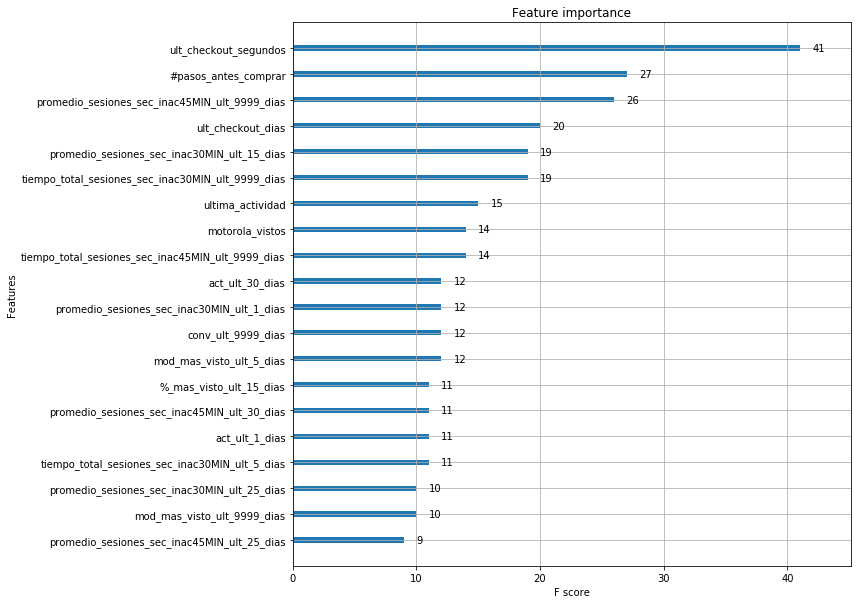

In [73]:
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(clf, ax=ax, max_num_features = 20)
plt.show()

In [252]:
X, X_test, y, y_test = train_test_split(features[features_usadas], targets, test_size = 0.3, random_state = 5)

In [347]:
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 5)
del X['person']
del X_test['person']

dtrain = xgb.DMatrix(X, label=y)
dtest = xgb.DMatrix(X_test, label=y_test)

In [260]:
xgb

<module 'xgboost' from 'C:\\Users\\RAUL\\Anaconda3\\lib\\site-packages\\xgboost\\__init__.py'>

In [261]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'binary:logistic',
}
params['eval_metric'] = "auc"

num_boost_round = 999
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[18:43:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[0]	Test-auc:0.838606
Will train until Test-auc hasn't improved in 10 rounds.
[18:43:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[1]	Test-auc:0.848009
[18:43:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[2]	Test-auc:0.861066
[18:43:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[3]	Test-auc:0.86817
[18:43:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[4]	Test-auc:0.872766
[18:43:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: 

In [262]:
print("Best AUC: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best AUC: 0.88 with 12 rounds


In [263]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=10
)

[18:44:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:44:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:44:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:44:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:44:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:44:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:44:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

In [317]:
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.904901,0.005651,0.854180,0.019226
1,0.905963,0.005508,0.854837,0.018503
2,0.906046,0.005556,0.854904,0.018215
3,0.906040,0.005503,0.855024,0.018987
4,0.906575,0.005722,0.855195,0.018724
5,0.906670,0.005705,0.855435,0.019098
6,0.907317,0.005779,0.856439,0.020540
7,0.907912,0.005991,0.856240,0.020657
8,0.908123,0.006041,0.856140,0.020912
9,0.909102,0.005999,0.856950,0.020410


In [215]:
cv_results['test-auc-mean'].max()

0.8659746

In [216]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [217]:
# Define initial best params and MAE
max_auc = 0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best MAE
    auc_mean = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(auc_mean, boost_rounds))
    if auc_mean > max_auc:
        max_auc = auc_mean
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

CV with max_depth=9, min_child_weight=5
[18:23:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[18:23:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[18:23:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[18:23:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[18:23:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[18:23:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[18:23:11] C:\Users\Administrator\Desktop\xgboost\src\

In [267]:
params['max_depth'] = 10
params['min_child_weight'] = 6

In [268]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [269]:
max_auc = 0
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best score
    auc_mean = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(auc_mean, boost_rounds))
    if auc_mean > max_auc:
        max_auc = auc_mean
        best_params = (subsample,colsample)

CV with subsample=1.0, colsample=1.0
[18:45:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[18:45:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[18:45:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[18:45:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[18:45:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[18:45:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[18:45:08] C:\Users\Administrator\Desktop\xgboost\src\tre

In [270]:
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

Best params: 1.0, 1.0, AUC: 0.8734734


In [271]:
params['subsample'] = 1.
params['colsample_bytree'] = 1.

In [272]:
%time
# This can take some time…
max_auc = 0
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,metrics=['auc'],early_stopping_rounds=10)
    # Update best score
    auc_mean = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(auc_mean, boost_rounds))
    if auc_mean > max_auc:
        max_auc = auc_mean
        best_params = eta

Wall time: 0 ns
CV with eta=0.3
[18:45:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[18:45:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[18:45:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[18:45:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[18:45:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[18:45:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[18:45:32] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

In [273]:
print("Best params: {}, AUC: {}".format(best_params, max_auc))

Best params: 0.3, AUC: 0.8734734


In [274]:
params['eta'] = .3

In [275]:
params

{'max_depth': 10,
 'min_child_weight': 6,
 'eta': 0.3,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

In [276]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[18:46:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[0]	Test-auc:0.857506
Will train until Test-auc hasn't improved in 10 rounds.
[18:46:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[1]	Test-auc:0.879797
[18:46:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[2]	Test-auc:0.878546
[18:46:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[3]	Test-auc:0.878136
[18:46:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[4]	Test-auc:0.879355
[18:46:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74

In [277]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[18:46:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[0]	Test-auc:0.857506
[18:46:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[1]	Test-auc:0.879797


In [278]:
dtest

In [318]:
best_model

In [180]:
best_model.save_model('0001.model')

In [182]:
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("0001.model")

In [319]:
params

{'max_depth': 10,
 'min_child_weight': 6,
 'eta': 0.3,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

In [367]:
best_model.predict(dMtest)

array([0.65962756, 0.31869492, 0.2659887 , 0.5499124 , 0.3651175 ,
       0.540753  , 0.3149337 , 0.33473757, 0.7212741 , 0.7212741 ,
       0.6735809 , 0.68341815, 0.7229963 , 0.7226372 , 0.2659887 ,
       0.5963882 , 0.2659887 , 0.48971978, 0.4578653 , 0.6735809 ,
       0.36208522, 0.67095447, 0.55284446, 0.2659887 , 0.7212741 ,
       0.48400253, 0.2659887 , 0.2659887 , 0.37864497, 0.7212741 ,
       0.2841456 , 0.7212741 , 0.60594726, 0.2659887 , 0.7212741 ,
       0.71464115, 0.6411333 , 0.30870894, 0.67095447, 0.34739754,
       0.36071846, 0.5170058 , 0.6806471 , 0.5521206 , 0.3697518 ,
       0.37893978, 0.3651175 , 0.722218  , 0.6303098 , 0.7212741 ,
       0.2659887 , 0.65962756, 0.33473757, 0.56981415, 0.7212741 ,
       0.63206655, 0.55758667, 0.2659887 , 0.6789602 , 0.3486414 ,
       0.2659887 , 0.39329433, 0.56981176, 0.3067981 , 0.67048395,
       0.4149166 , 0.7212741 , 0.31869492, 0.7212741 , 0.55284446,
       0.2841456 , 0.33743304, 0.2659887 , 0.45483622, 0.26598

In [345]:
X_test[['promedio_sesiones_sec_inac30MIN_ult_1_dias', 'mod_dist_check_ult_10_dias', 'conv_ult_5_dias', 'ult_checkout_dias', 'check_ult_5_dias', 'mod_dist_check_ult_5_dias', 'cant_sesiones_inac30MIN_ult_10_dias', '%_mas_visto_ult_1_dias', 'conv_ult_30_dias', 'check_ult_1_dias', 'compro', 'conv_ult_25_dias', '%_mas_visto_ult_30_dias', 'cant_sesiones_inac45MIN_ult_1_dias', 'conv_ult_20_dias', 'cant_sesiones_inac30MIN_ult_25_dias', 'ult_checkout_segundos', 'mod_dist_check_ult_1_dias', 'check_ult_15_dias', 'cant_sesiones_inac45MIN_ult_20_dias', 'act_ult_5_dias', 'total_vistos_ult_1_dias', 'cant_sesiones_inac45MIN_ult_15_dias', 'cant_sesiones_inac30MIN_ult_1_dias', 'conv_ult_1_dias', 'cant_sesiones_inac30MIN_ult_30_dias', 'mod_dist_check_ult_15_dias', 'total_vistos_ult_15_dias', 'cant_sesiones_inac45MIN_ult_30_dias', 'conv_ult_10_dias', 'act_ult_1_dias', 'conv_ult_9999_dias', 'mod_mas_visto_ult_5_dias', 'tiempo_total_sesiones_sec_inac30MIN_ult_20_dias', 'cant_sesiones_inac45MIN_ult_9999_dias', 'promedio_sesiones_sec_inac45MIN_ult_1_dias', 'motorola_vistos', 'tiempo_total_sesiones_sec_inac30MIN_ult_10_dias', 'conv_ult_15_dias', 'cant_sesiones_inac45MIN_ult_5_dias', 'cant_sesiones_inac45MIN_ult_10_dias', 'tiempo_total_sesiones_sec_inac45MIN_ult_1_dias', '#Camino', 'cant_sesiones_inac45MIN_ult_25_dias', 'cant_sesiones_inac30MIN_ult_15_dias', '%_mas_visto_ult_10_dias', 'check_ult_25_dias', 'total_vistos_ult_10_dias', '%_vistos_iphone', 'cant_sesiones_inac30MIN_ult_5_dias', 'mod_mas_visto_ult_1_dias']]

KeyError: "['promedio_sesiones_sec_inac30MIN_ult_1_dias' 'mod_dist_check_ult_10_dias'\n 'conv_ult_5_dias' 'ult_checkout_dias' 'check_ult_5_dias'\n 'mod_dist_check_ult_5_dias' 'cant_sesiones_inac30MIN_ult_10_dias'\n '%_mas_visto_ult_1_dias' 'conv_ult_30_dias' 'check_ult_1_dias' 'compro'\n 'conv_ult_25_dias' '%_mas_visto_ult_30_dias'\n 'cant_sesiones_inac45MIN_ult_1_dias' 'conv_ult_20_dias'\n 'cant_sesiones_inac30MIN_ult_25_dias' 'ult_checkout_segundos'\n 'mod_dist_check_ult_1_dias' 'check_ult_15_dias'\n 'cant_sesiones_inac45MIN_ult_20_dias' 'act_ult_5_dias'\n 'total_vistos_ult_1_dias' 'cant_sesiones_inac45MIN_ult_15_dias'\n 'cant_sesiones_inac30MIN_ult_1_dias' 'conv_ult_1_dias'\n 'cant_sesiones_inac30MIN_ult_30_dias' 'mod_dist_check_ult_15_dias'\n 'total_vistos_ult_15_dias' 'cant_sesiones_inac45MIN_ult_30_dias'\n 'conv_ult_10_dias' 'act_ult_1_dias' 'conv_ult_9999_dias'\n 'mod_mas_visto_ult_5_dias'\n 'tiempo_total_sesiones_sec_inac30MIN_ult_20_dias'\n 'cant_sesiones_inac45MIN_ult_9999_dias'\n 'promedio_sesiones_sec_inac45MIN_ult_1_dias' 'motorola_vistos'\n 'tiempo_total_sesiones_sec_inac30MIN_ult_10_dias' 'conv_ult_15_dias'\n 'cant_sesiones_inac45MIN_ult_5_dias'\n 'cant_sesiones_inac45MIN_ult_10_dias'\n 'tiempo_total_sesiones_sec_inac45MIN_ult_1_dias' '#Camino'\n 'cant_sesiones_inac45MIN_ult_25_dias'\n 'cant_sesiones_inac30MIN_ult_15_dias' '%_mas_visto_ult_10_dias'\n 'check_ult_25_dias' 'total_vistos_ult_10_dias' '%_vistos_iphone'\n 'cant_sesiones_inac30MIN_ult_5_dias' 'mod_mas_visto_ult_1_dias'] not in index"

In [366]:
dMtest = xgb.DMatrix(X_test)

In [320]:
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 5)
del X['person']
del X_test['person']

eval_set = [(X, y), (X_test, y_test)]
eval_metric = ["auc"]
clf = xgb.XGBClassifier(max_depth = 6)
clf.fit(X, y, eval_metric=eval_metric, eval_set=eval_set, verbose=False, xgb_model="0001.model")
y_pred = clf.predict(X_test)

In [171]:
X, X_test, y, y_test = train_test_split(features[features_usadas], targets, test_size = 0.3, random_state = 5)
#del X['person']
#del X_test['person']

eval_set = [(X, y), (X_test, y_test)]
eval_metric = ["auc"]
clf = xgb.XGBClassifier(
    params,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10)
clf.fit(X, y, eval_metric=eval_metric, eval_set=eval_set, verbose=False)
y_pred = clf.predict(X_test)

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001E985DA60B8>>
Traceback (most recent call last):
  File "C:\Users\RAUL\Anaconda3\lib\site-packages\xgboost\core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


XGBoostError: b"Invalid Parameter format for max_depth expect int but value='{'max_depth': 10, 'min_child_weight': 6, 'eta': 0.3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'objective': 'binary:logistic', 'eval_metric': 'auc'}'"

In [368]:
y_pred = best_model.predict(dMtest)

In [369]:
y_test['pred'] = pd.Series(y_pred).values

In [373]:
print (roc_auc_score(y_test['label'], y_test['pred']))

0.8797972255235009


In [350]:
test = personas.merge(trainingData, on = 'person', how = 'left', indicator = True)

In [351]:
test = test.drop_duplicates(subset ='person', keep = 'last')

In [352]:
test = test[test['_merge'] == 'left_only']

In [353]:
#del test['label']
del test['_merge']


In [354]:
test_X = test[list(X.columns.values)]

In [355]:
test_X

,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad,check_ult_9999_dias,check_ult_30_dias,check_ult_25_dias,check_ult_20_dias,check_ult_15_dias,check_ult_10_dias,check_ult_5_dias,check_ult_1_dias,ult_checkout_dias,ult_checkout_segundos,mod_dist_check_ult_9999_dias,mod_dist_check_ult_30_dias,mod_dist_check_ult_25_dias,mod_dist_check_ult_20_dias,mod_dist_check_ult_15_dias,mod_dist_check_ult_10_dias,mod_dist_check_ult_5_dias,mod_dist_check_ult_1_dias,act_ult_9999_dias,act_ult_30_dias,act_ult_25_dias,act_ult_20_dias,act_ult_15_dias,act_ult_10_dias,act_ult_5_dias,act_ult_1_dias,conv_ult_9999_dias,conv_ult_30_dias,conv_ult_25_dias,conv_ult_20_dias,conv_ult_15_dias,conv_ult_10_dias,conv_ult_5_dias,conv_ult_1_dias
1,31,708.0,21934.0,31.0,708.0,21934.0,27.0,761.0,20544.0,22.0,756.0,16625.0,14.0,830.0,11623.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,34,438.0,14890.0,34.0,438.0,14890.0,30.0,450.0,13500.0,24.0,505.0,12116.0,15.0,610.0,9149.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,61.0,251.0,55.0,367.0,0.166213,0.149864,0.683924,372.0,36.0,164.0,94.0,372.0,0.252688,94.0,372.0,0.252688,92.0,343.0,0.268222,92.0,307.0

In [356]:
dMtest = xgb.DMatrix(test_X)

In [598]:
#test_Y = clf.predict(test_X)

In [358]:
test_Y = best_model.predict(dMtest)

In [359]:
test['label'] = pd.Series(test_Y).values

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001E985D9F240>>
Traceback (most recent call last):
  File "C:\Users\RAUL\Anaconda3\lib\site-packages\xgboost\core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001E9F348B518>>
Traceback (most recent call last):
  File "C:\Users\RAUL\Anaconda3\lib\site-packages\xgboost\core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001E9F348BD68>>
Traceback (most recent call last):
  File "C:\Users\RAUL\Anaconda3\lib\site-packages\xgboost\core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound me

In [360]:
test

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad,check_ult_9999_dias,check_ult_30_dias,check_ult_25_dias,check_ult_20_dias,check_ult_15_dias,check_ult_10_dias,check_ult_5_dias,check_ult_1_dias,ult_checkout_dias,ult_checkout_segundos,mod_dist_check_ult_9999_dias,mod_dist_check_ult_30_dias,mod_dist_check_ult_25_dias,mod_dist_check_ult_20_dias,mod_dist_check_ult_15_dias,mod_dist_check_ult_10_dias,mod_dist_check_ult_5_dias,mod_dist_check_ult_1_dias,act_ult_9999_dias,act_ult_30_dias,act_ult_25_dias,act_ult_20_dias,act_ult_15_dias,act_ult_10_dias,act_ult_5_dias,act_ult_1_dias,conv_ult_9999_dias,conv_ult_30_dias,conv_ult_25_dias,conv_ult_20_dias,conv_ult_15_dias,conv_ult_10_dias,conv_ult_5_dias,conv_ult_1_dias,label
1,00091926,31,708.0,21934.0,31.0,708.0,21934.0,27.0,761.0,20544.0,22.0,756.0,16625.0,14.0,830.0,11623.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,34,438.0,14890.0,34.0,438.0,14890.0,30.0,450.0,13500.0,24.0,505.0,12116.0,15.0,610.0,9149.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,61.0,251.0,55.0,367.0,0.166213,0.149864,0.683924,372.0,36.0,164.0,94.0,372.0,0.252688,94.0,372.0,0.252688,92.0,343

In [362]:
date = str(datetime.datetime.now().strftime('%d_%m_%Y_%H_%M_%S'))
training_file_name = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\TP2\\Training Sets\\training_' + date + '.csv'
file_name = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\TP2\\Submits\\' + date + '.csv'

In [363]:
test[['person','label']].head()

,person,label
1,00091926,0.497419
2,00091a7a,0.714641
3,000ba417,0.381458
5,000e4d9e,0.586300
6,000e619d,0.328572


In [364]:
training.to_csv(training_file_name)
test[['person','label']].to_csv(file_name, index = False)

In [365]:
test[['person','label']].shape

(19415, 2)